In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และบันทึก RSI ที่จุดต่ำสุด
def detect_drip_with_rsi_at_low(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index และเวลาของ Low
            low_idx = data['low'].iloc[i:i+window].idxmin()
            rsi_at_low = data['RSI_14'].loc[low_idx] if low_idx in data.index else np.nan
            drips.append({
                'start_time': data.index[i],
                'low_time': low_idx,
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'rsi_at_low': rsi_at_low,
                'month': data.index[i].month
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))

# ตรวจจับ Drip และบันทึก RSI
drips = detect_drip_with_rsi_at_low(data)

In [5]:
# 1. การแจกแจงของ RSI ที่จุดต่ำสุดของ Drip
print("\nSummary of RSI at Drip Low:")
rsi_summary = {
    'Number of Drips': len(drips),
    'Mean RSI': drips['rsi_at_low'].mean(),
    'Std RSI': drips['rsi_at_low'].std(),
    'Min RSI': drips['rsi_at_low'].min(),
    'Max RSI': drips['rsi_at_low'].max(),
    'Median RSI': drips['rsi_at_low'].median()
}
for key, value in rsi_summary.items():
  print(f"{key}: {value:.2f}")


Summary of RSI at Drip Low:
Number of Drips: 710.00
Mean RSI: 34.98
Std RSI: 13.74
Min RSI: 4.37
Max RSI: 94.66
Median RSI: 33.38


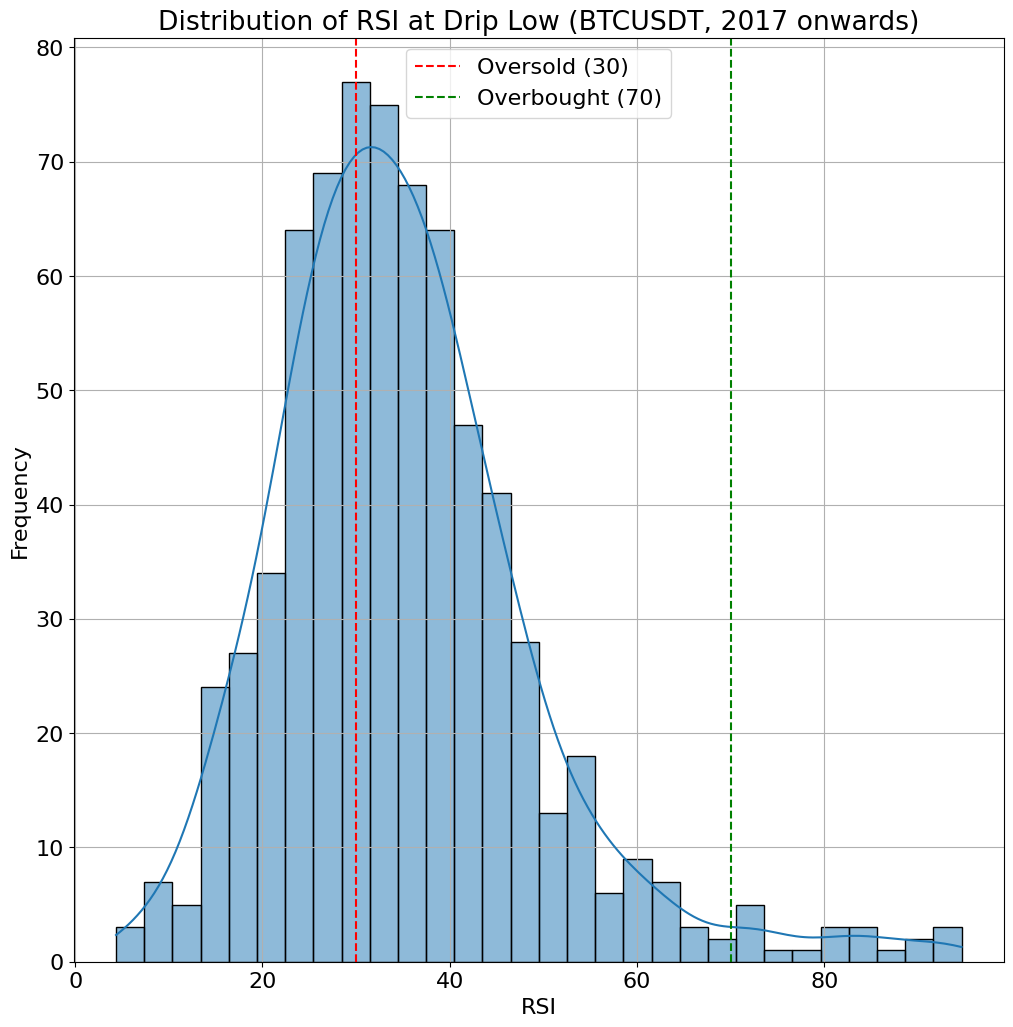

In [6]:
# สร้างฮิสโตแกรมของ RSI
plt.figure(figsize=(12, 12))
sns.histplot(drips['rsi_at_low'].dropna(), bins=30, kde=True)
plt.title('Distribution of RSI at Drip Low (BTCUSDT, 2017 onwards)')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.axvline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axvline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# ทดสอบความปกติของ RSI (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['rsi_at_low'].dropna())
print(f"\nShapiro-Wilk Test for RSI Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("RSI distribution is not normal (p < 0.05)")
else:
    print("RSI distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for RSI Normality: stat=0.9342, p-value=0.0000
RSI distribution is not normal (p < 0.05)


In [8]:
# 2. ค่าเฉลี่ย RSI ตามเดือน
monthly_rsi_means = drips.groupby('month')['rsi_at_low'].mean().reset_index()
monthly_rsi_means.columns = ['Month', 'Mean RSI']
print("\nMean RSI at Drip Low by Month:")
print(monthly_rsi_means.round(2))


Mean RSI at Drip Low by Month:
    Month  Mean RSI
0       1     37.17
1       2     37.64
2       3     33.22
3       4     36.10
4       5     35.35
5       6     32.96
6       7     35.05
7       8     31.30
8       9     28.37
9      10     40.26
10     11     31.82
11     12     39.20


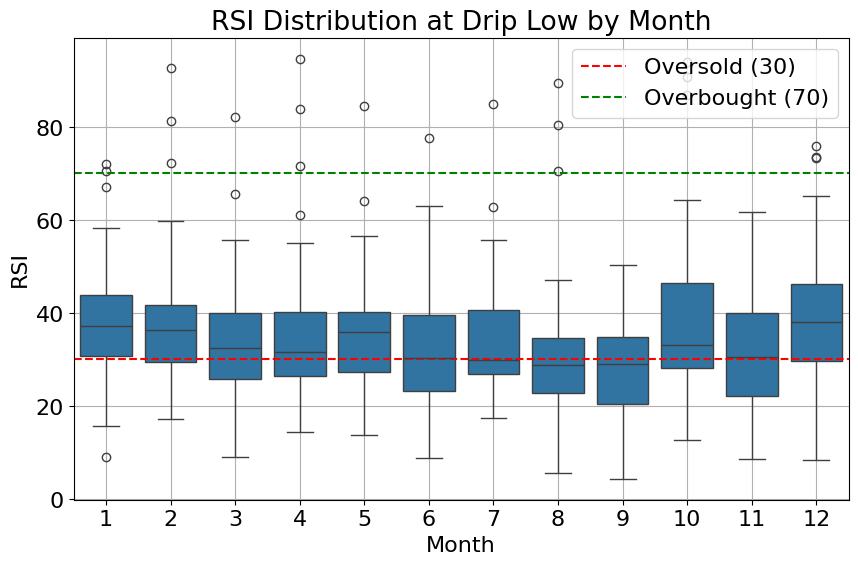

In [9]:
# สร้าง Boxplot เพื่อแสดงการกระจายของ RSI ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='rsi_at_low', data=drips)
plt.title('RSI Distribution at Drip Low by Month')
plt.xlabel('Month')
plt.ylabel('RSI')
plt.axhline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 3. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['rsi_at_low'].dropna() for month in drips['month'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test for RSI: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in mean RSI between months (p < 0.05)")
    else:
        print("No significant difference in mean RSI between months (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough months to perform the test.")


One-Way ANOVA Test for RSI: F=3.5408, p-value=0.0001
Significant difference in mean RSI between months (p < 0.05)


In [11]:
# 4. T-Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างคู่เดือน
print("\nT-Test Results for RSI (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_low'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for RSI (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9       1.0470   0.2979
1     8 vs 10      -1.8767   0.0651
2     8 vs 11      -0.1848   0.8538
3     8 vs 12      -2.9080   0.0043
4      8 vs 1      -2.4197   0.0169
..        ...          ...      ...
61     4 vs 6       1.0665   0.2886
62     4 vs 7       0.2916   0.7714
63     5 vs 6       1.0612   0.2906
64     5 vs 7       0.1121   0.9110
65     6 vs 7      -0.6981   0.4869

[66 rows x 3 columns]


In [12]:
# 5. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['rsi_at_low'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for RSI:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")


Tukey’s HSD Test Results for RSI:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2    0.474    1.0  -6.5922  7.5402  False
     1      3  -3.9519 0.7528  -10.737  2.8332  False
     1      4  -1.0713    1.0  -8.9956  6.8531  False
     1      5  -1.8162 0.9995  -8.8511  5.2187  False
     1      6  -4.2134 0.7412 -11.3785  2.9518  False
     1      7  -2.1161 0.9998 -11.0335  6.8013  False
     1      8  -5.8667 0.4537 -14.1113  2.3778  False
     1      9  -8.7991 0.0097 -16.4563 -1.1418   True
     1     10   3.0948 0.9972  -6.8277 13.0173  False
     1     11  -5.3442 0.3766 -12.5094   1.821  False
     1     12    2.028 0.9976  -4.5955  8.6515  False
     2      3  -4.4259 0.7257 -11.8613  3.0094  False
     2      4  -1.5453    1.0  -10.033  6.9425  False
     2      5  -2.2902 0.9981  -9.9541  5.3737  False
     2      6  -4.6874 0.7106 -12.4711  3.0964 

In [13]:
# 6. F-Test: เปรียบเทียบความแปรปรวน RSI ระหว่างคู่เดือน
print("\nF-Test Results for RSI Variance:")
f_test_results = []
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_low'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results for RSI Variance:
   Month Pair  F-Statistic  P-Value
0      8 vs 9       2.4251   0.0016
1     8 vs 10       1.9007   0.0488
2     8 vs 11       1.6953   0.0303
3     8 vs 12       1.5407   0.0502
4      8 vs 1       2.0592   0.0022
..        ...          ...      ...
61     4 vs 6       1.4492   0.0873
62     4 vs 7       1.4194   0.1509
63     5 vs 6       1.3965   0.0931
64     5 vs 7       1.4258   0.1363
65     6 vs 7       1.0210   0.4863

[66 rows x 3 columns]


In [14]:
# 7. Levene’s Test: เปรียบเทียบความแปรปรวน RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['rsi_at_low'].dropna() for month in drips['month'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for RSI Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough months to perform the test.")


Levene’s Test for RSI Variance: stat=1.1492, p-value=0.3197
No significant difference in variances (p >= 0.05)
